In [32]:
import torch 

In [33]:
import os 
import requests

pdf_path = "HyperTension.pdf"

if not os.path.exists(pdf_path):
    print(f"[INFO] failed to download the file.")
else:
    print(f"File {pdf_path} exists")


File HyperTension.pdf exists


In [34]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text:str) -> str:
    cleaned_text = text.replace("\n" , " "). strip()

    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text= text_formatter(text=text)
        pages_and_texts.append({"Page_number": page_number - 41, "page_char_count": len(text), 
                                "page_word_count": len(text.split(" ")),
                                 "page_sentence_count_raw": len(text.split(". ")),
                                  "page_token_count": len(text) /4,
                                   "text": text })
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'Page_number': -41,
  'page_char_count': 73,
  'page_word_count': 13,
  'page_sentence_count_raw': 1,
  'page_token_count': 18.25,
  'text': 'Guideline  for the pharmacological  treatment of  hypertension  in adults'},
 {'Page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [35]:
import pandas as pd 
df = pd.DataFrame(pages_and_texts)
df.head()

,Page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,73,13,1,18.25,Guideline for the pharmacological treatment ...
1,-40,0,1,1,0.00,
2,-39,73,13,1,18.25,Guideline for the pharmacological treatment ...
3,-38,3407,525,31,851.75,Guideline for the pharmacological treatment of...
4,-37,1666,317,2,416.50,Contents Acknowledgements v Acronyms and abbr...


In [36]:
from spacy.lang.en import English

nlp = English()

#Add a sentencizer

nlp.add_pipe("sentencizer")


In [37]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item['text']).sents)

    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    item["page_sentence_count_spacy"] = len(item["sentences"])


  0%|          | 0/61 [00:00<?, ?it/s]

In [38]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)


,Page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,61.00,61.00,61.00,61.00,61.00,61.00
mean,-11.00,2611.20,398.13,20.79,652.80,20.15
std,17.75,1280.78,195.22,21.11,320.19,19.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,-26.00,1895.00,293.00,4.00,473.75,5.00
50%,-11.00,2716.00,420.00,18.00,679.00,19.00
75%,4.00,3714.00,540.00,24.00,928.50,24.00
max,19.00,4571.00,702.00,77.00,1142.75,74.00


In [39]:
#chunking 
num_sentence_chunk_size = 10

def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]


In [40]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"], slice_size=num_sentence_chunk_size)

    item["num_chunks"] = len(item["sentence_chunks"])


  0%|          | 0/61 [00:00<?, ?it/s]

In [41]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)


,Page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,61.00,61.00,61.00,61.00,61.00,61.00,61.00
mean,-11.00,2611.20,398.13,20.79,652.80,20.15,2.49
std,17.75,1280.78,195.22,21.11,320.19,19.30,1.89
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,-26.00,1895.00,293.00,4.00,473.75,5.00,1.00
50%,-11.00,2716.00,420.00,18.00,679.00,19.00,2.00
75%,4.00,3714.00,540.00,24.00,928.50,24.00,3.00
max,19.00,4571.00,702.00,77.00,1142.75,74.00,8.00


In [42]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["Page_number"]

        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])',r'. \1', joined_sentence_chunk)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) /4 

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)


  0%|          | 0/61 [00:00<?, ?it/s]

152

In [43]:
df = pd.DataFrame(pages_and_chunks)


In [44]:
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count : {row[1]["chunk_token_count"]}| Text: {row[1]["sentence_chunk"]}')


Chunk token count : 21.75| Text: J Clin Endocrinol Metab.2019;104(5):1575-1584.doi: 10.1210/jc.2019-00197. REFERENCES 33
Chunk token count : 16.25| Text: In no event shall WHO be liable for damages arising from its use.
Chunk token count : 15.25| Text: Hypertens Res.2005;28(7):585-91.doi: 10.1291/hypres.28.585.32
Chunk token count : 18.25| Text: Guideline  for the pharmacological  treatment of  hypertension  in adults
Chunk token count : 4.25| Text: RECOMMENDATIONS 9


In [45]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"]> min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len


[{'page_number': -38,
  'sentence_chunk': 'Guideline for the pharmacological treatment of hypertension in adults ISBN 978-92-4-003398-6 (electronic version)  ISBN 978-92-4-003397-9 (print version) © World Health Organization 2021 Some rights reserved. This work is available under the Creative Commons Attribution-NonCommercial- ShareAlike 3.0 IGO licence (CC BY-NC-SA 3.0 IGO;   https://creativecommons.org/licenses/by-nc-sa/3.0/igo). Under the terms of this licence, you may copy, redistribute and adapt the work for non-commercial  purposes, provided the work is appropriately cited, as indicated below. In any use of this work, there  should be no suggestion that WHO endorses any specific organization, products or services. The use of  the WHO logo is not permitted. If you adapt the work, then you must license your work under the same  or equivalent Creative Commons licence. If you create a translation of this work, you should add the  following disclaimer along with the suggested citation

In [46]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")

sentences = ["The Sentence Transformer Library provides an easy way to create embeddings", "Sentences can be embeedded on by one or in a lost", "I like horses!"] 


embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")


Sentence: The Sentence Transformer Library provides an easy way to create embeddings
Embedding: [-3.17512788e-02  3.37267555e-02 -2.52437796e-02  5.22288419e-02
 -2.35249791e-02 -6.19116891e-03  1.35025457e-02 -6.25501350e-02
  7.50831934e-03 -2.29684897e-02  2.98145972e-02  4.57555614e-02
 -3.26700620e-02  1.39847612e-02  4.18013632e-02 -5.92969507e-02
  4.26310077e-02  5.04655251e-03 -2.44552530e-02  3.98591487e-03
  3.55898216e-02  2.78742742e-02  1.84098873e-02  3.67699228e-02
 -2.29961611e-02 -3.01796887e-02  5.99619874e-04 -3.64504606e-02
  5.69104776e-02 -7.49941776e-03 -3.70004103e-02 -3.04364343e-03
  4.64355052e-02  2.36149481e-03  9.06849550e-07  7.00036297e-03
 -3.92289162e-02 -5.95697155e-03  1.38653331e-02  1.87106046e-03
  5.34202717e-02 -6.18613772e-02  2.19613519e-02  4.86051328e-02
 -4.25697267e-02 -1.69858467e-02  5.04178256e-02  1.54733518e-02
  8.12860429e-02  5.07106557e-02 -2.27496810e-02 -4.35721017e-02
 -2.18382338e-03 -2.14091577e-02 -2.01758258e-02  3.0683226

In [47]:
%%time


# Extract the sentence chunks
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

# Generate embeddings on CPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"], device='cpu')


  0%|          | 0/144 [00:00<?, ?it/s]

CPU times: total: 2min 58s
Wall time: 28.5 s


In [48]:
%%time 
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size =32, convert_to_tensor=True )


CPU times: total: 5min 30s
Wall time: 28.5 s


In [49]:
## Save Embeddings 
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunk_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)


In [50]:
text_chunks_and_embeddings_df_load = pd.read_csv("text_chunk_and_embeddings_df.csv")


In [51]:
import random
import torch
import numpy as np
import pandas as pd


text_chunks_and_embeddings_df = pd.read_csv("text_chunk_and_embeddings_df.csv")

text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x:np.fromstring(x.strip("[]") , sep=" "))

embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to("cpu")

pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-38,Guideline for the pharmacological treatment of...,1397,208,349.25,"[0.0322975218, -0.0188721679, 0.014344709, -0...."
1,-38,Suggested citation. Guideline for the pharmaco...,489,60,122.25,"[0.0216960125, 0.00495383004, 0.00708221132, -..."
2,-38,If you wish to reuse material from this work t...,1447,238,361.75,"[0.00337434001, -0.0488039851, -0.0180421919, ..."
3,-37,Contents Acknowledgements v Acronyms and abbr...,1666,317,416.50,"[0.0141956815, -0.00343135116, -0.0108614815, ..."
4,-36,GUIDELINE FOR THE PHARMACOLOGICAL TREATMENT OF...,477,84,119.25,"[-0.01271402, -0.00567622669, 0.0340060741, -0..."
...,...,...,...,...,...,...
139,14,GUIDELINE FOR THE PHARMACOLOGICAL TREATMENT OF...,1893,276,473.25,"[0.0176240001, 0.0242444444, 0.0281273257, 0.0..."
140,15,3 Should cardiovascular risk assessment be us...,2465,356,616.25,"[-0.0361399166, 0.00163900817, 0.0244934186, -..."
141,16,GUIDELINE FOR THE PHARMACOLOGICAL TREATMENT OF...,2105,314,526.25,"[-0.00463372748, 0.00236869091, 0.0237291511, ..."
142,17,8 In adults with hypertension requiring pharm...,2217,313,554.25,"[-0.0135790417, 0.0218906719, 0.0332062095, 0...."


In [52]:
embeddings.shape


torch.Size([144, 768])

In [53]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")


In [54]:
query = "hypertension special settings"
print(f'Query : {query}')

#Embed query
query_embedding = embedding_model.encode(query,convert_to_tensor=True).to("cpu")

#Get similarity scores
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time= timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")

#Get the top-k results 

top_results_dot_product = torch.topk(dot_scores, k = 1)


Query : hypertension special settings
[INFO] Time taken to get scores on 144 embeddings: 0.00026 seconds


In [55]:
large_embeddings = torch.randn(100*embeddings.shape[0],768).to("cpu")
print(f'Embeddings shape: {large_embeddings.shape}')

# Perform dot product
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=large_embeddings)[0]
end_time = timer()

print(
    f"[INFO] Time taken to get scores on {len(large_embeddings)} embeddings: {end_time - start_time:.5f} seconds"
)


Embeddings shape: torch.Size([14400, 768])
[INFO] Time taken to get scores on 14400 embeddings: 0.00186 seconds


In [56]:
import textwrap


def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)


In [57]:
pages_and_chunks[0]


{'page_number': -38,
 'sentence_chunk': 'Guideline for the pharmacological treatment of hypertension in adults ISBN 978-92-4-003398-6 (electronic version)  ISBN 978-92-4-003397-9 (print version) © World Health Organization 2021 Some rights reserved. This work is available under the Creative Commons Attribution-NonCommercial- ShareAlike 3.0 IGO licence (CC BY-NC-SA 3.0 IGO;   https://creativecommons.org/licenses/by-nc-sa/3.0/igo). Under the terms of this licence, you may copy, redistribute and adapt the work for non-commercial  purposes, provided the work is appropriately cited, as indicated below. In any use of this work, there  should be no suggestion that WHO endorses any specific organization, products or services. The use of  the WHO logo is not permitted. If you adapt the work, then you must license your work under the same  or equivalent Creative Commons licence. If you create a translation of this work, you should add the  following disclaimer along with the suggested citation: 

In [58]:
query = "hypertension special settings"
print(f'Query: {query} \n')
print('Results:')
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print('\n')


Query: hypertension special settings 

Results:
Score: 0.7077
Text:
GUIDELINE FOR THE PHARMACOLOGICAL TREATMENT OF HYPERTENSION IN ADULTS 6
Implementation tools 6.1 Guideline recommendations Graphic summaries of the
guideline recommendations are presented below in an algorithmic approach  (Figs
3 and 4). This maps the recommendations to a patient-care pathway. Fig.3 An
approach for starting treatment with a single-pill combination  Treat adults
with BP ≥140 mmHg or ≥90   (SBP ≥130 mmHg for those with CVD, DM, CKD). Start
two-drug combination therapy, preferably in a single-pill combination  (ACE/ARB,
dihydropyridine CCB, thiazide-like agents). Treatment targets: <140/90 mmHg
(SBP <130 mmHg for high-risk patients with CVD, DM, CKD). Follow up monthly
after initiation or a change in antihypertensive  medications until patient
reaches BP target. Follow up every 3–6 months for patients with BP under
control. Pharmacological treatment to be initiated under the following
circumstances: [  A 

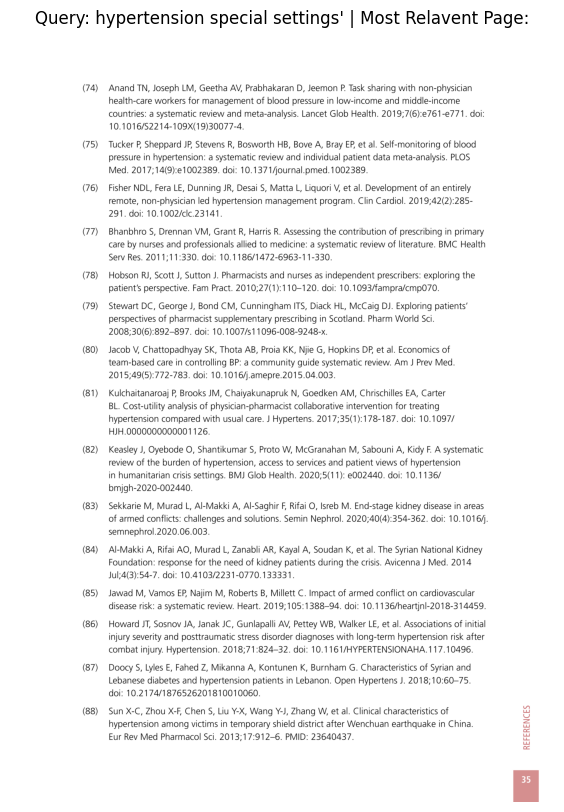

In [59]:
import fitz

pdf_path = "HyperTension.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41)

img  = page.get_pixmap(dpi=300)

doc.close()

img_array = np.frombuffer(img.samples_mv, dtype = np.uint8).reshape((img.h, img.w, img.n))


import matplotlib.pyplot as plt
plt.figure(figsize = (13,10))
plt.imshow(img_array)
plt.title(f"Query: {query}' | Most Relavent Page:")
plt.axis('off')
plt.show()


In [60]:
def retrieve_relavent_resources(query: str, embeddings: torch.tensor, 
                                model: SentenceTransformer= embedding_model, 
                                n_resources_to_return: int=5, 
                                print_time: bool = True):
    
    """
    Embeds a query with model and returns top k scores and indices from embeddings
    """

    #Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)}) embeddings: {end_time-start_time:.5f}seconds")
    
    scores, indices = torch.topk(input=dot_scores, k = n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query:str, 
                                 embeddings: torch.tensor, 
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    scores, indices = retrieve_relavent_resources(query=query, embeddings=embeddings,n_resources_to_return=n_resources_to_return)
    print("Results:")
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
        print("\n")


In [61]:
query = "hypertension covid"
retrieve_relavent_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)


[INFO] Time taken to get scores on (144) embeddings: 0.00026seconds
[INFO] Time taken to get scores on (144) embeddings: 0.00010seconds
Results:
Score: 0.7043
Text:
Geneva: World Health Organization; June 2021
(WHO/2019-nCoV/Sci_Brief/Hypertension/2021.1, accessed July 2021). (93)
Richardson S, Hirsch JS, Narasimhan M, Crawford JM, McGinn T, the Northwell
COVID-19  Research Consortium, et al. Presenting characteristics, comorbidities,
and outcomes among 5700  patients hospitalized with COVID-19 in the New York
City Area. JAMA.2020;323(20):2052-2059. doi: 10.1001/jama.2020.6775. Erratum in:
JAMA.2020 May 26;323(20):2098. (94)  Xie J, Tong Z, Guan X, Du B, Qiu H.
Clinical characteristics of patients who died of  coronavirus disease 2019 in
China. JAMA Netw Open.
Page Number: 6


Score: 0.6978
Text:
GUIDELINE FOR THE PHARMACOLOGICAL TREATMENT OF HYPERTENSION IN ADULTS 4.2
COVID-19 and hypertension Almost all available evidence suggests that
hypertension increases the risk of severe COVID-

In [62]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

input_text = "Write me a poem about Machine Learning."
input_ids = tokenizer(input_text, return_tensors="pt").to("cpu")

outputs = model.generate(**input_ids, max_new_tokens=32)
print(tokenizer.decode(outputs[0]))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk and cpu.


<bos>Write me a poem about Machine Learning.

A tapestry of data, woven tight,
A million threads of knowledge, shining bright.
Machine learning, a weaver's art,
Unravel


In [63]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Define model ID
model_id = "google/gemma-2-2b-it"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the model for CPU use
llm_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,  # use float16 only if your CPU supports it (rare)
    low_cpu_mem_usage=True
)

# Move model to CPU explicitly (optional, but safe)
llm_model.to("cpu")

# Example prompt
prompt = "What is the impact of hypertension on cardiovascular health?"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt")

# Generate response
with torch.no_grad():
    outputs = llm_model.generate(**inputs, max_new_tokens=100)

# Decode and print response
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

What is the impact of hypertension on cardiovascular health?

Hypertension, also known as high blood pressure, is a major risk factor for cardiovascular disease (CVD). It puts a strain on your heart and blood vessels, increasing the likelihood of various heart problems. 

Here's a breakdown of the impact of hypertension on cardiovascular health:

**1. Heart Attack and Stroke:**

* **Increased risk:** Hypertension significantly elevates the risk of both heart attacks and strokes. 
* **Damage to blood vessels:** High blood pressure damages the


In [64]:
llm_model


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [65]:
def get_model_num_params(model:torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)


2614341888

In [66]:
def get_model_mem_size(model: torch.nn.Module):
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers
    model_mem_gb = model_mem_bytes / (1024**3)
    model_mem_mb = model_mem_bytes / (1024**2)

    return {"model_mem_bytes" : model_mem_bytes, "model_mem_mb": round(model_mem_mb,2), "model_mem_gb": round(model_mem_gb,2)}

get_model_mem_size(llm_model)


{'model_mem_bytes': 10457368064, 'model_mem_mb': 9972.92, 'model_mem_gb': 9.74}

In [67]:
input_text = "What are the effects of hypertension on the human body? Can you provide a brief overview?"

print(f"Input Text:\n{input_text}")

#Creating a prompt template

dialogue_template = [
    {"role":"user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template, 
                                       tokenize=False, 
                                       add_generation_prompt=True)

print(f"\nPrompt:\n {prompt}")


Input Text:
What are the effects of hypertension on the human body? Can you provide a brief overview?

Prompt:
 <bos><start_of_turn>user
What are the effects of hypertension on the human body? Can you provide a brief overview?<end_of_turn>
<start_of_turn>model



In [68]:
%%time

#Tokenize the input text

input_ids = tokenizer(prompt, return_tensors='pt').to("cpu")


outputs = llm_model.generate(**input_ids, max_new_tokens = 256)
print(f"Model output (tokens):\n{outputs[0]}\n")


Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573,   5701,
           576,  58292,    611,    573,   3515,   2971, 235336,   2551,    692,
          3658,    476,   9091,  23330, 235336,    107,    108,    106,   2516,
           108,   1620,    714,  20815,    576, 156246,    611,    573,   9998,
         14427, 235292,    586,  20199,  20855,    109,  38954,  37935, 235269,
           689,   1536,   5330,   5601, 235269,    603,    476,  19887,  31005,
        235265,   1165, 235303, 235256,   3695,   3151,    573,    664,  71188,
         31005, 235281,   1861,    665,   3695,    919,    793,  12447, 235269,
          3547,    665,   5988,    577,  21422,   3274,   6449,   7042,    919,
          3303,  12414, 235265, 235248,    109,   4858, 235303, 235256,    476,
          9091,  23330,    576,    573,   5701,    576,  58292,    611,    573,
          3515,   2971, 235292,    109,    688,  14298, 235290,   7617,   5701,
         66058,  

In [69]:
#Decode the output

outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model Output(decoded):\n{outputs_decoded}\n")


Model Output(decoded):
<bos><bos><start_of_turn>user
What are the effects of hypertension on the human body? Can you provide a brief overview?<end_of_turn>
<start_of_turn>model
## The Effects of Hypertension on the Human Body: A Brief Overview

Hypertension, or high blood pressure, is a silent killer. It's often called the "silent killer" because it often has no symptoms, making it difficult to detect until serious damage has already occurred. 

Here's a brief overview of the effects of hypertension on the human body:

**Short-term effects:**

* **Headaches:**  A common symptom, often described as a throbbing or pounding sensation.
* **Dizziness:**  Feeling lightheaded or unsteady.
* **Nosebleeds:**  Frequent or heavy nosebleeds.
* **Shortness of breath:**  Difficulty breathing, especially during exertion.
* **Chest pain:**  A feeling of tightness or pressure in the chest.
* **Vision problems:**  Blurred vision, double vision, or seeing spots.

**Long-term effects:**

* **Heart disease

In [70]:
gpt4_questions = [
    "What is hypertension and how is it clinically diagnosed?",
    "What are the primary and secondary causes of hypertension?",
    "How does high blood pressure affect the heart, brain, kidneys, and eyes?",
    "What lifestyle changes are recommended to manage or prevent hypertension?",
    "Explain the role of sodium and potassium in regulating blood pressure.",
    "What are the common classes of antihypertensive medications and how do they work?",
    "How is blood pressure measured, and what do systolic and diastolic values indicate?",
    "What are the long-term health risks associated with uncontrolled hypertension?",
    "How do stress and mental health impact blood pressure levels?",
    "Describe the DASH diet and its effectiveness in managing hypertension.",
]
manual_questions = [
     "What is hypertension?",
    "How is blood pressure measured?",
    "What causes high blood pressure?",
    "What are symptoms of hypertension?",
    "What foods increase blood pressure?"
]

query_list = gpt4_questions + manual_questions
query_list


['What is hypertension and how is it clinically diagnosed?',
 'What are the primary and secondary causes of hypertension?',
 'How does high blood pressure affect the heart, brain, kidneys, and eyes?',
 'What lifestyle changes are recommended to manage or prevent hypertension?',
 'Explain the role of sodium and potassium in regulating blood pressure.',
 'What are the common classes of antihypertensive medications and how do they work?',
 'How is blood pressure measured, and what do systolic and diastolic values indicate?',
 'What are the long-term health risks associated with uncontrolled hypertension?',
 'How do stress and mental health impact blood pressure levels?',
 'Describe the DASH diet and its effectiveness in managing hypertension.',
 'What is hypertension?',
 'How is blood pressure measured?',
 'What causes high blood pressure?',
 'What are symptoms of hypertension?',
 'What foods increase blood pressure?']

In [71]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

scores,indices = retrieve_relavent_resources(query=query, embeddings=embeddings)
scores, indices


Query: What causes high blood pressure?
[INFO] Time taken to get scores on (144) embeddings: 0.00091seconds


(tensor([0.5706, 0.4918, 0.4725, 0.4568, 0.4520]),
 tensor([13, 92, 16, 14,  7]))

In [72]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "- " + "\n - ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
        Give yourself room to think by extracting relevant passages from the context before answering the query.
        Don't return the thinking, only return the answer.
        Make sure your answers are as explanatory as possible.
        Use the following examples as reference for the ideal answer style.
        Clearly identifies a specific real-world challenge faced by women in 
the financial ecosystem. Proposes an AI based innovation that 
supports economic empowerment, personalized financial literacy, or 
inclusive access to credit. 
● Prioritizes ethical use of AI (e.g., bias mitigation, privacy, fairness) 
and accessibility for all women, including those with low tech or 
literacy levels.
        \nNow use the following context items to answer the user query:
        {context}
        \nRelevant passages: <extract relevant passages from the context here>
        User query: {query}
        Answer:"""

    base_prompt = base_prompt.format(context=context, query=query)

    dialogue_template = [
    {"role":"user",
     "content": base_prompt}
        ]

    prompt = tokenizer.apply_chat_template(conversation=dialogue_template, 
                                       tokenize=False, 
                                       add_generation_prompt=True)

    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relavent_resources(query=query, 
                                              embeddings=embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query,context_items=context_items )
print(prompt)


Query: What lifestyle changes are recommended to manage or prevent hypertension?
[INFO] Time taken to get scores on (144) embeddings: 0.00010seconds
<bos><start_of_turn>user
Based on the following context items, please answer the query.
        Give yourself room to think by extracting relevant passages from the context before answering the query.
        Don't return the thinking, only return the answer.
        Make sure your answers are as explanatory as possible.
        Use the following examples as reference for the ideal answer style.
        Clearly identifies a specific real-world challenge faced by women in 
the financial ecosystem. Proposes an AI based innovation that 
supports economic empowerment, personalized financial literacy, or 
inclusive access to credit. 
● Prioritizes ethical use of AI (e.g., bias mitigation, privacy, fairness) 
and accessibility for all women, including those with low tech or 
literacy levels.
        
Now use the following context items to answer

In [73]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

outputs = llm_model.generate(**input_ids, 
                            temperature=0.7, 
                            do_sample = True, 
                            max_new_tokens = 256)

output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG Answer:\n {output_text.replace(prompt,'')}")


Query: What lifestyle changes are recommended to manage or prevent hypertension?
RAG Answer:
 <bos>The text states that non-pharmacological approaches for managing hypertension include:

* **Reducing salt intake** to less than 5g daily.
* **Eating more fruit and vegetables** 
* **Being physically active on a regular basis**
* **Avoiding the use of tobacco**
* **Reducing alcohol consumption**
* **Limiting the intake of foods high in saturated fats**
* **Eliminating/reducing trans fats in the diet** 
<end_of_turn>
CPU times: total: 2min 56s
Wall time: 1min 35s


In [77]:
def ask(query: str, 
        temperature: float = 0.7, 
        max_new_tokens: int=256,
        format_answer_text=True, 
        return_answer_only=True):
    
    """
    Takes a query, find relevant resouces/context and generates an answer.
    """

    scores,indices = retrieve_relavent_resources(query=query, 
                                                  embeddings=embeddings)
    
    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    
    prompt = prompt_formatter(query=query, 
                              context_items=context_items)
    
    input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

    outputs = llm_model.generate(**input_ids, 
                                 temperature=temperature, 
                                 do_sample = True,
                                 max_new_tokens=max_new_tokens)
    
    output_text = tokenizer.decode(outputs[0])
    if format_answer_text:
        output_text = output_text.replace(prompt,"").replace("<bos>", "").replace("<eos>", "").replace("<end_of_turn", "")
    
    if return_answer_only:
        return output_text
    
    return output_text, context_items


In [78]:
%%time

query = random.choice(query_list)
print(f"Query: {query}")
ask(query=query)


Query: What is hypertension?
[INFO] Time taken to get scores on (144) embeddings: 0.00014seconds
CPU times: total: 4min 16s
Wall time: 33.9 s


'Hypertension, also known as high blood pressure, is a serious medical condition where the force of blood against the walls of arteries is elevated.  It can be defined using specific systolic and diastolic blood pressure levels or by reporting the use of antihypertensive medications. High blood pressure significantly increases the risk for heart, brain, kidney, and other organ diseases. \n>'